In [15]:
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import matplotlib.pyplot as plt
import torch

from laplace import Laplace, marglik_training

from helper.dataloaders import get_sinusoid_example
from helper.util import plot_regression

In regression case, GP posterior has a closed form solution and there is no need to do Laplace GP approximation (contrary to the classification case). When all datapoints are used for fitting the posterior, i.e. we do not use SoD approximation with $M < N$, the GP posterior mean has the following form:

$$
f_* := k(x_*, X) \big(k(X, X) + \sigma^2 I_N \big) \cdot \big(\mathbf{y} - m(X)\big) + m(x_*) , \quad m(X) = f(X) + J_{\theta_{MAP}}(\theta_0 - \theta_{MAP})
$$

Note how this is different from the GP posterior mean based on the Laplace GP approximation (here mean corresponds to the outputs of the NN): $f_* = f(x_*)$ 

https://stats.stackexchange.com/questions/450332/gaussian-process-how-to-interpret-the-posterior

In [19]:
torch.manual_seed(711)

In [3]:
# create toy regression data
X_train, y_train, train_loader, X_test = get_sinusoid_example(sigma_noise=0.3)

In [4]:
n_epochs = 1000

# construct single layer neural network
def get_model():
    torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Linear(1, 50), torch.nn.Tanh(), torch.nn.Linear(50, 1)
    )
model = get_model()

# train MAP
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

sigma=0.276 |  prior precision=0.194 |  MAE (NN): 4.526 |  MAE (GP): 5.131


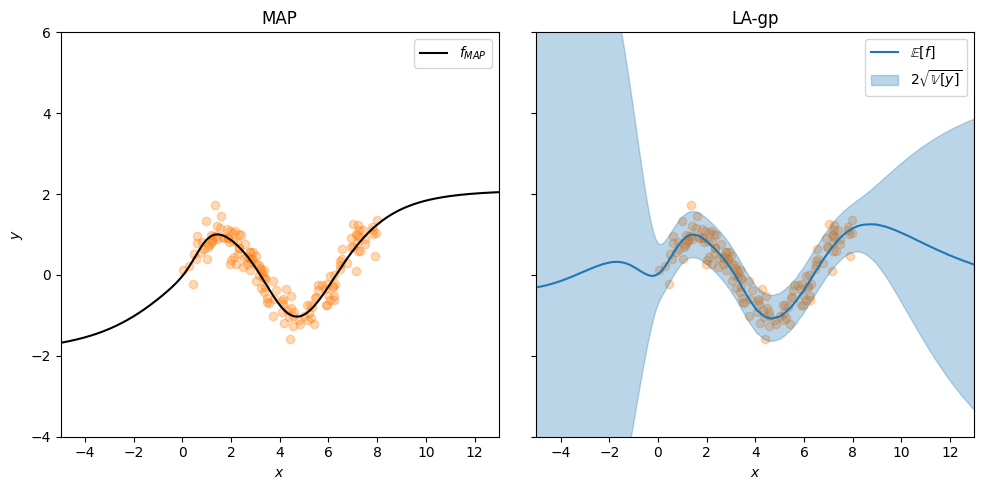

In [5]:
la_type = 'gp'

la = Laplace(model, 'regression', subset_of_weights='all', hessian_structure=la_type)

la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
if la_type == 'gp':
    la._build_Sigma_inv()

x = X_test.flatten().cpu().numpy()
f_mu, f_var, f_mu_gp = la.gp_posterior(X_test, return_gp_mean=True)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
f_mu_gp = f_mu_gp.squeeze().detach().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

print(f'sigma={la.sigma_noise.item():.3f} | ',
      f'prior precision={la.prior_precision.item():.3f} | ',
      f'MAE (NN): {np.abs(x - f_mu).mean():.3f} | ',
      f'MAE (GP): {np.abs(x - f_mu_gp).mean():.3f}')

plot_regression(X_train, y_train, x, f_mu, f_mu_gp, pred_std,
                file_name='regression_example', plot=True, la_type=la_type, figsize=(10, 5))

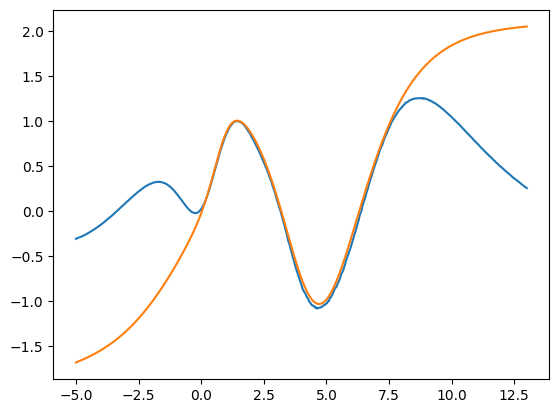

In [14]:
plt.plot(X_test, f_mu_gp, label='GP')
plt.plot(X_test, f_mu, label='NN')
plt.show()

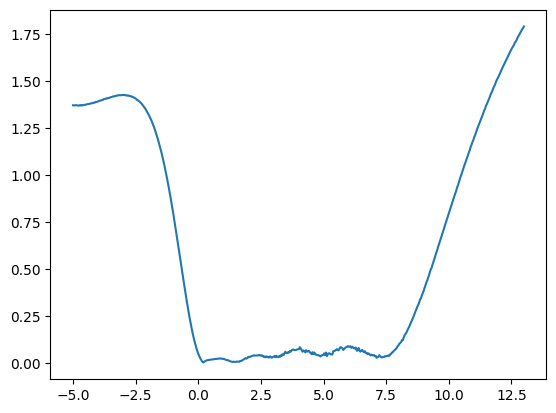

In [13]:
plt.plot(X_test, np.abs((f_mu - f_mu_gp)))
plt.show()

sigma=0.275 |  prior precision=0.145 |  MAE: 4.278 |  MAE (GP): 6.182


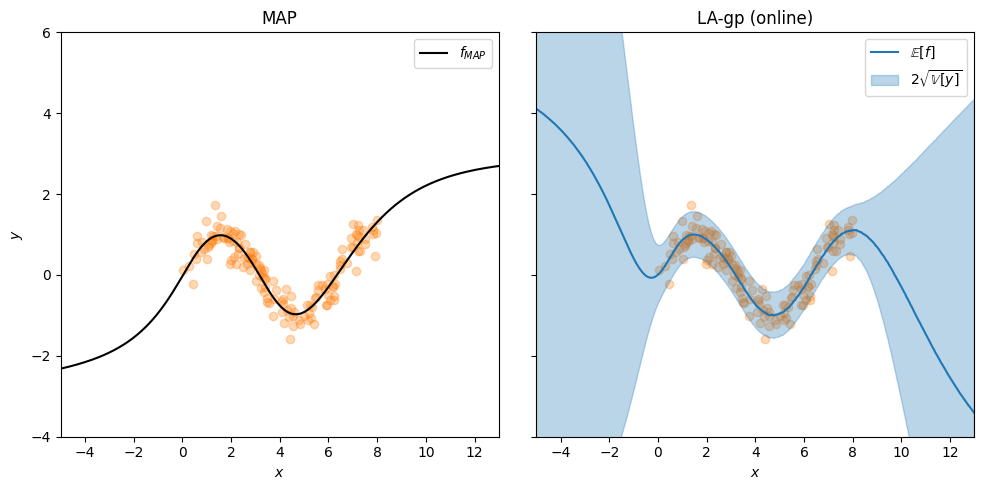

In [18]:
model = get_model()
la, model, margliks, losses = marglik_training(
    model=model, train_loader=train_loader, likelihood='regression',
    hessian_structure=la_type, backend=BackPackGGN, n_epochs=n_epochs,
    optimizer_kwargs={'lr': 1e-2}, prior_structure='scalar'
)

f_mu, f_var, f_mu_gp = la.gp_posterior(X_test, return_gp_mean=True)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
f_mu_gp = f_mu_gp.squeeze().detach().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

print(f'sigma={la.sigma_noise.item():.3f} | ',
      f'prior precision={la.prior_precision.numpy()[0]:.3f} | ',
      f'MAE: {np.abs(x - f_mu).mean():.3f} | ',
      f'MAE (GP): {np.abs(x - f_mu_gp).mean():.3f}')

plot_regression(X_train, y_train, x, f_mu, f_mu_gp, pred_std,
                file_name='regression_example_online', plot=True, la_type=la_type + " (online)", figsize=(10, 5))